# Dataset

In [14]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
from diffusion_utilities import *

Files already downloaded and verified


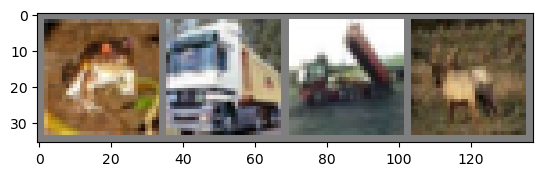

frog  truck truck deer 


In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define a transform to normalize the data
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# Download and load the training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=False, num_workers=2)

# Define the classes in CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [16]:
classes[1], classes[7]

('automobile', 'horse')

# Setting Things Up

In [120]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=32):  # cfeat - context features
        super(ContextUnet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4, so 28,24,20,16...

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True) # 3x3, padding 1. applies 2 times. outputs 256 channels

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[batch, 256, 16, 16]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[batch, 256, 8,  8]
        self.down3 = UnetDown(2 * n_feat, 2 * n_feat)    # down3 #[bacth, 256, 4,  4]


         # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 2*n_feat)
        self.timeembed3 = EmbedFC(1, n_feat)
        #self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        #self.contextembed2 = EmbedFC(n_cfeat, 2*n_feat)
        #self.contextembed3 = EmbedFC(n_cfeat, n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//8, self.h//8), # up-sample
            nn.GroupNorm(8, 2 * n_feat), # normalize
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, 2 * n_feat)
        self.up2 = UnetUp(4 * n_feat, n_feat)
        self.up3 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on
        #print(f"Input shape: {x.shape}")
        #we begin 3x32x32
        x = self.init_conv(x) # feat x 32 x 32
        #print(f"After init_conv shape: {x.shape}")
        down1 = self.down1(x) # feat x 16 x 16
        #print(f"After down1 shape: {down1.shape}")
        down2 = self.down2(down1) # 2feat x 8 x 8
        #print(f"After down2 shape: {down2.shape}")
        down3 = self.down3(down2) # 2feat x 4 x 4
        #print(f"After down3 shape: {down3.shape}")

        hiddenvec = self.to_vec(down3) #IT IS NOT A VECTOR, WE HAVE 2FEAT X 4 X 4
        #print(f"Hidden vector shape: {hiddenvec.shape}")

        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x) # (batch, cfeat)

        # embed context and timestep
        #cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        #cemb2 = self.contextembed2(c).view(-1, self.n_feat * 2, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat * 2, 1, 1)
        #cemb3 = self.contextembed3(c).view(-1, self.n_feat , 1, 1)
        temb3 = self.timeembed3(t).view(-1, self.n_feat , 1, 1)


        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        # up1 = self.up0(hiddenvec)
        # up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        # up3 = self.up2(cemb2*up2 + temb2, down1)
        # print(f"Shape of up3 before final concat: {up3.shape}")
        # print(f"Shape of x before final concat: {x.shape}")
        # # Ensure up3 and x have the same height and width before concatenation
        # if up3.shape[2:] != x.shape[2:]:
        #     up3 = nn.functional.interpolate(up3, size=x.shape[2:], mode='nearest')
        up1 = self.up0(hiddenvec)
        #print(f"After up0 shape: {up1.shape}")

        up2 = self.up1(up1 + temb1, down3)
        #print(f"After up1 shape: {up2.shape}")

        up3 = self.up2(up2 + temb2, down2)
        #print(f"After up2 shape: {up3.shape}")

        up4 = self.up3(up3 + temb3, down1)
        #print(f"After up3 shape: {up4.shape}")


        out = self.out(torch.cat((up4, x), 1))
        return out


In [121]:
# hyperparameters

# diffusion hyperparameters
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
#device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
device = torch.device("mps" if torch.backends.mps.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 10 # context vector is of size 10
height = 32 # 16x16 image
save_dir = './weights/'
chan = 3

# training hyperparameters
batch_size = 128
n_epoch = 20
lrate=1e-4

In [122]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1

In [123]:
# construct model
nn_model = ContextUnet(in_channels=chan, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

In [124]:
device

device(type='mps')

# Choose dataset

In [125]:
transform

Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

In [126]:
mask_1 = torch.Tensor(trainset.targets) == 3
mask_2 = torch.Tensor(trainset.targets) == 8
mask = mask_1 | mask_2
trainset = torch.utils.data.Subset(trainset, torch.where(mask)[0])

AttributeError: 'Subset' object has no attribute 'targets'

In [127]:
len(trainset)

10000

# Training

In [128]:

dataloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

In [129]:
# helper function: perturbs an image to a specified noise level 
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

In [130]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load("weights_1000/MNIST_15-027.pth", map_location=device))
print("Loaded in Model without context")

FileNotFoundError: [Errno 2] No such file or directory: 'weights_1000/MNIST_15-027.pth'

In [131]:
n_epoch = 2

In [132]:
# training without context code
l_min = 1
# set into train mode
nn_model.train()

for ep in range(n_epoch):
    print(f'epoch {ep}')
    
    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    
    pbar = tqdm(dataloader, mininterval=2 )
    for x, _ in pbar:   # x: images
        optim.zero_grad()
        x = x.to(device)
        
        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device) 
        x_pert = perturb_input(x, t, noise)
        
        # use network to recover noise
        pred_noise = nn_model(x_pert, t / timesteps)
        
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()
        
        optim.step()
    print("Loss = ", loss.item())
    # save model periodically
    if ep%10==0 or ep == int(n_epoch-1) or l_min>loss.item():
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        if l_min>loss.item():
            l_min = loss.item()
        torch.save(nn_model.state_dict(), save_dir + f"MNIST_{ep}.pth")
        print('saved model at ' + save_dir + f"MNIST_{ep}.pth")
        

epoch 0


  0%|          | 0/79 [00:00<?, ?it/s]

After init_conv shape: torch.Size([128, 64, 32, 32])
After down1 shape: torch.Size([128, 64, 16, 16])
After down2 shape: torch.Size([128, 128, 8, 8])
After down3 shape: torch.Size([128, 128, 4, 4])
Hidden vector shape: torch.Size([128, 128, 1, 1])
After up0 shape: torch.Size([128, 128, 4, 4])
After up1 shape: torch.Size([128, 128, 8, 8])
After up2 shape: torch.Size([128, 64, 16, 16])
After up3 shape: torch.Size([128, 64, 32, 32])


  1%|▏         | 1/79 [00:11<15:17, 11.77s/it]

After init_conv shape: torch.Size([128, 64, 32, 32])
After down1 shape: torch.Size([128, 64, 16, 16])
After down2 shape: torch.Size([128, 128, 8, 8])
After down3 shape: torch.Size([128, 128, 4, 4])
Hidden vector shape: torch.Size([128, 128, 1, 1])
After up0 shape: torch.Size([128, 128, 4, 4])
After up1 shape: torch.Size([128, 128, 8, 8])
After up2 shape: torch.Size([128, 64, 16, 16])
After up3 shape: torch.Size([128, 64, 32, 32])
After init_conv shape: torch.Size([128, 64, 32, 32])
After down1 shape: torch.Size([128, 64, 16, 16])
After down2 shape: torch.Size([128, 128, 8, 8])
After down3 shape: torch.Size([128, 128, 4, 4])
Hidden vector shape: torch.Size([128, 128, 1, 1])
After up0 shape: torch.Size([128, 128, 4, 4])
After up1 shape: torch.Size([128, 128, 8, 8])
After up2 shape: torch.Size([128, 64, 16, 16])
After up3 shape: torch.Size([128, 64, 32, 32])
After init_conv shape: torch.Size([128, 64, 32, 32])
After down1 shape: torch.Size([128, 64, 16, 16])
After down2 shape: torch.Size(

  5%|▌         | 4/79 [00:13<03:27,  2.77s/it]

After init_conv shape: torch.Size([128, 64, 32, 32])
After down1 shape: torch.Size([128, 64, 16, 16])
After down2 shape: torch.Size([128, 128, 8, 8])
After down3 shape: torch.Size([128, 128, 4, 4])
Hidden vector shape: torch.Size([128, 128, 1, 1])
After up0 shape: torch.Size([128, 128, 4, 4])
After up1 shape: torch.Size([128, 128, 8, 8])
After up2 shape: torch.Size([128, 64, 16, 16])
After up3 shape: torch.Size([128, 64, 32, 32])


  5%|▌         | 4/79 [00:15<04:53,  3.92s/it]


KeyboardInterrupt: 

In [18]:
for x in dataloader:
    a = x
    break

In [21]:
a[1]

tensor([3, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 3, 3, 3, 3, 3, 8, 8, 8, 8, 3, 8, 8, 8,
        3, 3, 3, 3, 8, 3, 8, 3, 8, 8, 8, 3, 3, 8, 8, 3, 3, 8, 3, 3, 8, 8, 3, 3,
        3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 3, 8, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3,
        8, 3, 3, 8, 8, 8, 3, 8, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 8, 8, 3, 3, 3,
        3, 3, 3, 3, 3, 8, 3, 8, 3, 8, 3, 3, 8, 3, 3, 3, 8, 3, 8, 3, 3, 8, 3, 3,
        3, 8, 3, 8, 3, 8, 3, 3])